<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#J1-J2棋盘格模型" data-toc-modified-id="J1-J2棋盘格模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>J1-J2棋盘格模型</a></span></li><li><span><a href="#格点MPO" data-toc-modified-id="格点MPO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>格点MPO</a></span></li><li><span><a href="#程序检验" data-toc-modified-id="程序检验-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>程序检验</a></span><ul class="toc-item"><li><span><a href="#J1-J2-MC" data-toc-modified-id="J1-J2-MC-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>J1-J2 MC</a></span></li><li><span><a href="#bond强度比例-r" data-toc-modified-id="bond强度比例-r-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>bond强度比例 r</a></span></li><li><span><a href="#温度-β" data-toc-modified-id="温度-β-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>温度 β</a></span></li></ul></li></ul></div>

## J1-J2棋盘格模型
横向纵向连接耦合强度为$J_1,J_2$交替排布，形成红色正方形和黑色正方形棋盘格
<img src="figure/29.png" width="40%">

## 格点MPO
权重张量为$M$
<img src="figure/30.png" width="25%">
红色连接上张量为
$\exp(-J_2 h_{ij})$, $J_2 = r J_1$

要收缩的目标张量Z2为
<img src="figure/31.png" width="25%">

能量权重张量为$ME$
<img src="figure/32.png" width="25%">

In [44]:
# call library
using LinearAlgebra, TensorOperations, KrylovKit, Random, Statistics, PyPlot, ProgressMeter, Test

include("src/nontrivialVUMPS.jl")
include("src/muti-MC.jl")

MutiMC (generic function with 1 method)

In [7]:
Threads.nthreads()

60

## 程序检验
### J1-J2 MC

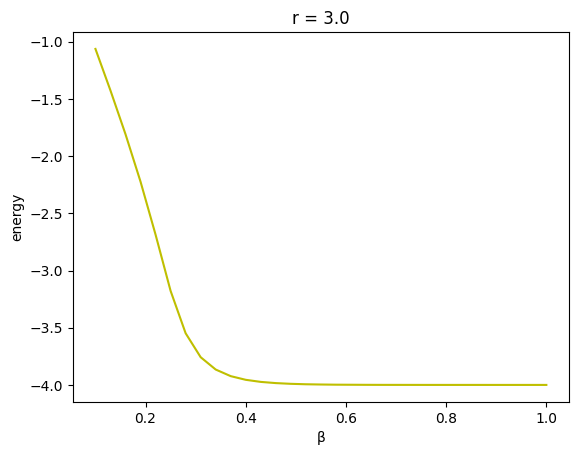

  7.954380 seconds (191.14 M allocations: 3.227 GiB, 33.46% gc time)


PyObject Text(24.000000000000007, 0.5, 'energy')

In [3]:
#test1
lattice = 8;               #晶格大小
Sweeps_heat = Int(1e4);       #热浴蒙卡次数
Sweeps = Int(1e6);           #蒙卡次数
βB = 0.1;                    #温度区间初始
βE = 1;                    #温度区间末尾
d = 0.03;                   #温度区间间隔
steps = Int(round((βE-βB)/d+1));
# mag_ave = zeros(steps,1);  
ene_ave = zeros(steps,1);
r = 3.0
@time begin
    Threads.@threads for i=1:steps
        β = βB+ d*(i-1);
        ene_ave[i] = MC(lattice,β,r,Sweeps_heat,Sweeps)
    end
end
β=βB:d:βE
# subplots_adjust(wspace=0.5)
# suptitle("r = $r")
# subplot(221)
# plot(β,mag_ave,"r")
# xlabel("β")
# ylabel("magnetic")

# subplot(222)
title("r = $r")
plot(β,ene_ave,"y")
xlabel("β")
ylabel("energy")

### bond强度比例 r

r  = 1 
Step 1: err ≈ 0.0015127854504356022
Step 2: err ≈ 6.334826163347057e-9
r  = 2 
Step 1: err ≈ 0.002952836059229717
Step 2: err ≈ 1.3595667524210006e-7
r  = 3 
Step 1: err ≈ 0.004252955003845263
Step 2: err ≈ 5.447437536207237e-7
r  = 4 
Step 1: err ≈ 0.004976248947480782
Step 2: err ≈ 1.4827751722011222e-6
Step 3: err ≈ 3.274995283539364e-13
r  = 5 
Step 1: err ≈ 0.005448730811594239
Step 2: err ≈ 1.8480459477657591e-6
Step 3: err ≈ 1.2793927296053311e-12
r  = 6 
Step 1: err ≈ 0.005439916911854895
Step 2: err ≈ 3.760277495279803e-6
Step 3: err ≈ 1.3732376484958397e-11
r  = 7 
Step 1: err ≈ 0.00557432856965202
Step 2: err ≈ 4.547176985109281e-6
Step 3: err ≈ 2.752123327265186e-11
r  = 8 
Step 1: err ≈ 0.005426166417191576
Step 2: err ≈ 6.318105202269383e-6
Step 3: err ≈ 2.417843050902122e-11
r  = 9 
Step 1: err ≈ 0.005559044779376786
Step 2: err ≈ 7.376088148692276e-6
Step 3: err ≈ 1.2189134436077237e-10
r  = 10 
Step 1: err ≈ 0.0055586598076878
Step 2: err ≈ 1.3874872552711782e-

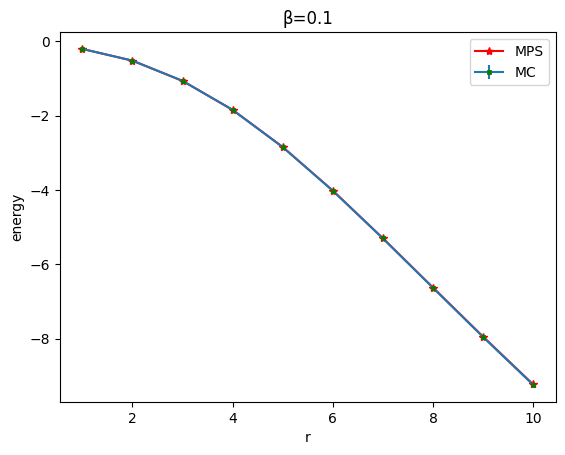

PyObject Text(0.5, 1.0, 'β=0.1')

In [14]:
#test4 muti-data
β= 0.1
lattice = 8
lB = 1;                    
lE = 10;                    
ld = 1;
steps = Int(round((lE-lB)/ld+1));
eMC = zeros(steps,1)
err = zeros(steps,1)
eMPS = zeros(steps,1)
Bins = 1
bins = 60
Sweeps_heat = Int(1e4)
Sweeps = Int(1e5)

Ni = 2
Nj = 2
D = 50
A = Array{Array,2}(undef, Ni, Nj)

for i=1:steps
    r = lB+ ld*(i-1);
    println("r  = $r ")
    eMC[i],err[i] = MutiMC(β,r,lattice,Bins,bins,Sweeps_heat,Sweeps)
    for i = 1:Ni,j = 1:Nj
        Random.seed!(1234)
        A[i,j] = randn(D, 2, D) + im*randn(D, 2, D)
    end
    M, ME,λM,λME = classicalisingmpo(β; r = r)
    λ, AL, C, AR, FL3, FR3, FL4, FR4 = vumps(A, M;verbose = true, tol = 1e-6, maxiter = 100)
    eMPS[i] = real(energy(M, ME, AL, C, AR, FL3,FL4, FR3, FR4,λM,λME))
end

r = lB:ld:lE
errorbar(r,reshape(eMC,steps,),yerr = reshape(err,steps,),marker="s", mfc="red",
                 mec="green", ms=2, mew=2,label = "MC")
plot(r,eMPS,"*-",color = "r",label = "MPS")
legend(loc="best")
xlabel("r")
ylabel("energy")
title("β=$β")

r  = 1 
r  = 2 
r  = 3 
r  = 4 
r  = 5 
r  = 6 
r  = 7 
r  = 8 
r  = 9 
r  = 10 


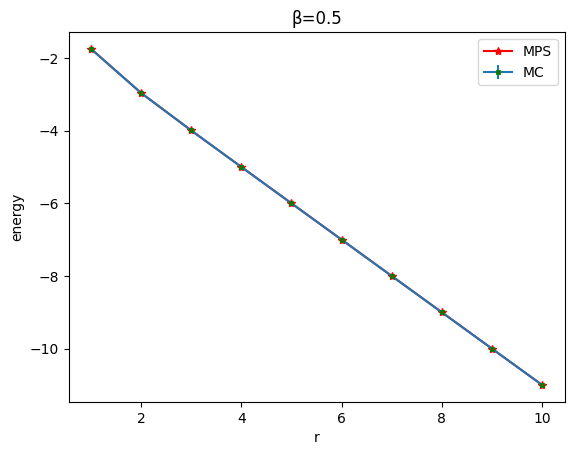

PyObject Text(0.5, 1.0, 'β=0.5')

In [45]:
#test4 muti-data
β= 0.5
lattice = 8
lB = 1;                    
lE = 10;                    
ld = 1;
steps = Int(round((lE-lB)/ld+1));
eMC = zeros(steps,1)
err = zeros(steps,1)
eMPS = zeros(steps,1)
Bins = 1
bins = 60
Sweeps_heat = Int(1e5)
Sweeps = Int(2*1e5)

Ni = 2
Nj = 2
D = 50
A = Array{Array,2}(undef, Ni, Nj)

for i=1:steps
    r = lB+ ld*(i-1);
    println("r  = $r ")
    eMC[i],err[i] = MutiMC(β,r,lattice,Bins,bins,Sweeps_heat,Sweeps)
    for i = 1:Ni,j = 1:Nj
        Random.seed!(1234)
        A[i,j] = randn(D, 2, D) + im*randn(D, 2, D)
    end
    M, ME,λM,λME = classicalisingmpo(β; r = r)
    λ, AL, C, AR, FL3, FR3, FL4, FR4 = vumps(A, M;verbose = true, tol = 1e-6, maxiter = 100)
    eMPS[i] = real(energy(M, ME, AL, C, AR, FL3,FL4, FR3, FR4,λM,λME))
end

r = lB:ld:lE
errorbar(r,reshape(eMC,steps,),yerr = reshape(err,steps,),marker="s", mfc="red",
                 mec="green", ms=2, mew=2,label = "MC")
plot(r,eMPS,"*-",color = "r",label = "MPS")
legend(loc="best")
xlabel("r")
ylabel("energy")
title("β=$β")

### 温度 β

β  = 0.1 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


Step 1: err ≈ 0.0054419094735996265
Step 2: err ≈ 1.3630442166818118e-6
Step 3: err ≈ 1.051064198588269e-12
Step 4: err ≈ 4.942334679085088e-16
β  = 0.13 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


Step 1: err ≈ 0.004169420084252499
Step 2: err ≈ 3.019644200099613e-6
Step 3: err ≈ 8.706503022014479e-12
Step 4: err ≈ 3.4419683483247388e-15
Step 5: err ≈ 2.0084907800614257e-16
β  = 0.16 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


Step 1: err ≈ 0.0024045480876356087
Step 2: err ≈ 2.25224879251252e-6
Step 3: err ≈ 1.206556873064556e-10
Step 4: err ≈ 2.526335475676282e-13
Step 5: err ≈ 4.1183410947280556e-15
Step 6: err ≈ 2.2332502347055927e-16
β  = 0.19 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Step 1: err ≈ 0.005114143993993893
Step 2: err ≈ 6.801780908884088e-5
Step 3: err ≈ 2.2130188964497623e-7
Step 4: err ≈ 1.872227845214918e-10
Step 5: err ≈ 5.040030130074396e-12
Step 6: err ≈ 1.3795734964690743e-13
Step 7: err ≈ 1.2415362901406196e-14
Step 8: err ≈ 2.1105023131071948e-15
Step 9: err ≈ 6.403565933980634e-16
β  = 0.22 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


Step 1: err ≈ 0.0028652577906495354
Step 2: err ≈ 0.00012901129127149372
Step 3: err ≈ 3.0108985093740565e-5
Step 4: err ≈ 3.552081046618049e-6
Step 5: err ≈ 1.0169753547052195e-7
Step 6: err ≈ 3.6354415977846723e-9
Step 7: err ≈ 3.1879065465529136e-10
Step 8: err ≈ 5.742326823089163e-11
Step 9: err ≈ 1.8883275514636652e-11
Step 10: err ≈ 6.281048441317483e-12
Step 11: err ≈ 2.942505075338548e-12
Step 12: err ≈ 1.421900998246596e-12
Step 13: err ≈ 6.602332472580849e-13
Step 14: err ≈ 4.1732976984865607e-13
Step 15: err ≈ 2.7510578591916093e-13
Step 16: err ≈ 2.4869710674396934e-13
Step 17: err ≈ 1.8971944229088534e-13
Step 18: err ≈ 1.9780309221766995e-13
Step 19: err ≈ 1.4561196377950214e-13
Step 20: err ≈ 1.418944482272428e-13
Step 21: err ≈ 1.1055084798738656e-13
Step 22: err ≈ 1.1201743197948223e-13
Step 23: err ≈ 9.842997965585199e-14
Step 24: err ≈ 1.0564180241797687e-13
Step 25: err ≈ 1.0359473515598593e-13
Step 26: err ≈ 1.137917573067463e-13
Step 27: err ≈ 1.1047060747278087e-

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Step 1: err ≈ 0.005814406715086242
Step 2: err ≈ 2.520139053067025e-5
Step 3: err ≈ 1.7301475987188924e-6
Step 4: err ≈ 7.794824091358271e-8
Step 5: err ≈ 3.5755626260287736e-9
Step 6: err ≈ 1.4835097515668448e-10
Step 7: err ≈ 1.7652152580318682e-11
Step 8: err ≈ 1.9917656874831636e-12
Step 9: err ≈ 5.109444879360843e-13
Step 10: err ≈ 1.134192739293398e-13
Step 11: err ≈ 4.452618168482393e-14
Step 12: err ≈ 2.0834002540331716e-14
Step 13: err ≈ 8.370358223327523e-15
Step 14: err ≈ 2.924242840217991e-15
Step 15: err ≈ 1.2679900946961275e-15
Step 16: err ≈ 8.864500729845705e-16
β  = 0.28 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Step 1: err ≈ 0.003333948501451352
Step 2: err ≈ 7.868844208731526e-6
Step 3: err ≈ 8.934817110485104e-8
Step 4: err ≈ 8.924348959340432e-10
Step 5: err ≈ 1.579918651389099e-11
Step 6: err ≈ 4.866084062602321e-13
Step 7: err ≈ 2.987964367429745e-14
Step 8: err ≈ 2.783526179205506e-15
Step 9: err ≈ 3.4110024940369335e-16
β  = 0.31 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Step 1: err ≈ 0.002736701354126264
Step 2: err ≈ 2.9965919433139e-6
Step 3: err ≈ 2.8226512346846632e-9
Step 4: err ≈ 1.1995408275095136e-11
Step 5: err ≈ 2.0235003240574836e-13
Step 6: err ≈ 4.236995064736541e-15
Step 7: err ≈ 3.1248550275055317e-16
β  = 0.33999999999999997 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Step 1: err ≈ 0.003177525567398878
Step 2: err ≈ 1.5624113136735453e-6
Step 3: err ≈ 3.769472614508495e-10
Step 4: err ≈ 1.4886704436021332e-12
Step 5: err ≈ 1.4680097556028907e-14
Step 6: err ≈ 9.559435067085454e-16
β  = 0.37 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


Step 1: err ≈ 0.0025294695677629546
Step 2: err ≈ 3.367077061794835e-6
Step 3: err ≈ 5.0962161620677045e-11
Step 4: err ≈ 5.254481546473637e-14
Step 5: err ≈ 4.643935720891474e-16
β  = 0.4 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


Step 1: err ≈ 0.0025156684643310957
Step 2: err ≈ 3.423577036186171e-6
Step 3: err ≈ 5.7671799114200476e-11
Step 4: err ≈ 2.3768143974522064e-14
Step 5: err ≈ 3.400685605146005e-16


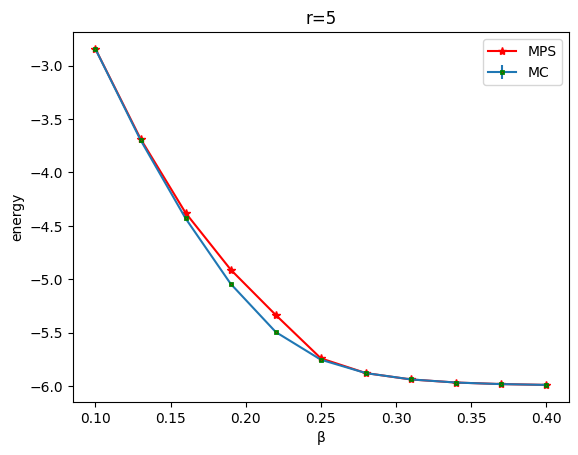

PyObject Text(0.5, 1.0, 'r=5')

In [41]:
r = 5
lattice = 8
lB = 0.1;                    
lE = 0.4;                    
ld = 0.03;
steps = Int(round((lE-lB)/ld+1));
eMC = zeros(steps,1)
err = zeros(steps,1)
eMPS = zeros(steps,1)
Bins = 10
bins = 60
Sweeps_heat = Int(1e5)
Sweeps = Int(2*1e5)

Ni = 2
Nj = 2
D = 50
A = Array{Array,2}(undef, Ni, Nj)

for i=1:steps
    β = lB+ ld*(i-1)
    println("β  = $β ")
    eMC[i],err[i] = MutiMC(β,r,lattice,Bins,bins,Sweeps_heat,Sweeps)
    for i = 1:Ni,j = 1:Nj
        Random.seed!(1234)
        A[i,j] = randn(D, 2, D) + im*randn(D, 2, D)
    end
    M, ME,λM,λME = classicalisingmpo(β; r = r)
    λ, AL, C, AR, FL3, FR3, FL4, FR4 = vumps(A, M;verbose = true, tol = 1e-15, maxiter = 100)
    eMPS[i] = real(energy(M, ME, AL, C, AR, FL3,FL4, FR3, FR4,λM,λME))
end

β = lB:ld:lE
errorbar(β,reshape(eMC,steps,),yerr = reshape(err,steps,),marker="s", mfc="red",
                 mec="green", ms=2, mew=2,label = "MC")
plot(β,eMPS,"*-",color = "r",label = "MPS")
legend(loc="best")
xlabel("β")
ylabel("energy")
title("r=$r")